In [1]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, BertModel, BertForSequenceClassification, BertTokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Concatenate, GlobalAveragePooling1D
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from torchsummary import summary
import tensorflow as tf
import datasets
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from time import time
import gc

In [2]:
class Sample:
    pass

class Factual_info:
    def __init__(self,text):
         self.text = text
         self.sent = [0,0,0]
         self.sent_pred = 0
         self.off = 0
         self.off_pred = 0
         self.hate_peace = 0
         self.peace_pred = 0
         self.hate_gen = 0
         self.gen_pred = 0
         self.hate_hateBERT = 0
         self.hateBERT_pred = 0
         self.sem_emb = 0
    
    def print_info(self):
        print("Text:")
        print(self.text)
        print()
        print("Sentiment")
        print("Negative:",self.sent[0])
        print("Neutral:",self.sent[1])
        print("Positive:",self.sent[2])
        print()
        print("Offense:",self.off)
        print()
        print("Hate of PEACE:",self.hate_peace)
        print()
        print("Hate of the general module:",self.hate_gen)
        print()
        print("Hate of HateBERT:",self.hate_hateBERT)
        
class Metrics:
    def __init__(self):
        self.dist_sent = 0
        self.dist_off = 0
        self.same_sent = 0
        self.distinct_off = 0
        self.off_improvement = 0
        self.sem_sim = 0
    
    def print_metrics(self):
        print("Metrics")
        print("Sentiment distance:",self.dist_sent)
        print("Offense distance:",self.dist_off)
        print()
        print("Same Sentiment:",self.same_sent)
        print("Distinct Offense:",self.distinct_off)
        print("Offense improvement:",self.off_improvement)
        print()
        print("Sentence similarity:",self.sem_sim)
        

# Causal modules

In [3]:
#roBERTa models
sent_MOD = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
aggr_MOD = f"cardiffnlp/twitter-roberta-base-offensive"

#Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained(sent_MOD)
sent_class_mod = AutoModelForSequenceClassification.from_pretrained(sent_MOD)
aggr_class_mod = AutoModelForSequenceClassification.from_pretrained(aggr_MOD)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def Compute_Caus_Outs(tokenizer,sent_mod,aggr_mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out_1 = []
  batch_out_2 = []
  for batch in batches:
      encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')
      # Compute the outputs of the modules as numpy arrays.
      emb_1 = sent_mod(**encoded_inputs)[0]
      scores_1 = []
      for i in range(emb_1.shape[0]):
            scores_1.append(softmax(emb_1[i].detach().numpy()))
      scores_1 = np.array(scores_1)
      batch_out_1.append(scores_1)  

      emb_2 = aggr_mod(**encoded_inputs)[0]
      scores_2 = []
      for i in range(emb_2.shape[0]):
            scores_2.append(softmax(emb_2[i].detach().numpy()))
      scores_2 = np.array(scores_2)
      batch_out_2.append(scores_2)
    
      encoded_inputs = None
      emb_1 = None
      emb_2 = None
      gc.collect() 
    
  outs_sent = np.concatenate(batch_out_1,axis=0)
  outs_aggr = np.concatenate(batch_out_2,axis=0)  

  return outs_sent,outs_aggr

## Loading the factuals

In [5]:
def get_texts(df):
    np_array = df["text"].to_numpy()
    texts = []
    for i in range(len(np_array)):
        texts.append(np_array[i])
    return texts

In [6]:
df_factuals = pd.read_csv('data/factuals.tsv',sep='\t')
factuals = get_texts(df_factuals)
labels_factuals = df_factuals["label"].to_numpy()

In [7]:
samples = []
for i in range(len(factuals)):
    samples.append(Sample())
    samples[i].factual = Factual_info(factuals[i])

## Loading the sentiment and offense of the factuals

In [8]:
class_fact_sent = np.load('outs/counterfactuals/class_fact_sent.npy')
class_fact_off = np.load('outs/counterfactuals/class_fact_off.npy')
factual_sent = np.load('outs/counterfactuals/factual_sent.npy')
factual_off = np.load('outs/counterfactuals/factual_off.npy')

In [9]:
for i in range(len(samples)):
    samples[i].factual.sent = class_fact_sent[i]
    samples[i].factual.sent_pred = factual_sent[i]
    samples[i].factual.off = class_fact_off[i][1]
    samples[i].factual.off_pred = factual_off[i] 

## Loading the counterfactuals

In [10]:
n_cf = 5
df_cf_off = pd.read_csv('data/cf_off.tsv',sep='\t')
cf_off = get_texts(df_cf_off)

In [11]:
metrics_cf_off = []
i = 0
for j in range(0,len(cf_off),n_cf):
    cf = []
    met = []
    for k in range(n_cf):
        cf.append(Factual_info(cf_off[j+k]))
        met.append(Metrics())
    samples[i].cf_off = cf.copy()
    metrics_cf_off.append(met.copy())
    i+=1

## Getting the counterfactuals output (If they are already saved you can skip this step)

In [12]:
def print_causal_result(text,sent,aggr):
    print("Text:")
    print(text)
    print()
    print("Sentiment")
    print("Negative:",sent[0])
    print("Neutral:",sent[1])
    print("Positive:",sent[2])
    print()
    print("Aggression")
    print("Not offensive:",aggr[0])
    print("Offensive:",aggr[1])
    
def print_causal_results(texts,sents,aggrs):
    for i in range(len(texts)):
        print_causal_result(texts[i],sents[i],aggrs[i])
        print()
        print()

In [13]:
batch_size = 32

cf_pred_sent = []
cf_pred_off = []
t = time()
class_cf_sent,class_cf_off = Compute_Caus_Outs(tokenizer,sent_class_mod,aggr_class_mod,cf_off,batch_size)
print("Elapsed time:",time()-t)
for i in range(len(cf_off)):
        cf_pred_sent.append(class_cf_sent[i].argmax())
        cf_pred_off.append(class_cf_off[i].argmax())    
#print_causal_results(counterfactuals,class_cfact_sent,class_cfact_aggr)

Elapsed time: 1952.1373901367188


In [14]:
np.save('outs/counterfactuals/class_cf_sent.npy',class_cf_sent)
np.save('outs/counterfactuals/class_cf_off.npy',class_cf_off)
np.save('outs/counterfactuals/cf_pred_sent.npy',cf_pred_sent)
np.save('outs/counterfactuals/cf_pred_off.npy',cf_pred_off)

## Loading the counterfactuals output

In [12]:
class_cf_sent = np.load('outs/counterfactuals/class_cf_sent.npy')
class_cf_off = np.load('outs/counterfactuals/class_cf_off.npy')
cf_pred_sent = np.load('outs/counterfactuals/cf_pred_sent.npy')
cf_pred_off = np.load('outs/counterfactuals/cf_pred_off.npy')

In [13]:
i = 0
for j in range(0,len(cf_off),n_cf):
    for k in range(n_cf):
        samples[i].cf_off[k].sent = class_cf_sent[j+k]
        samples[i].cf_off[k].sent_pred = cf_pred_sent[j+k]
        samples[i].cf_off[k].off = class_cf_off[j+k][1]
        samples[i].cf_off[k].off_pred = cf_pred_off[j+k]
    i+=1

# Hate models

## Load train data embeddings

In [14]:
frenk_sent_train = np.load('outs/frenk/sent_train_outs.npy')
frenk_aggr_train = np.load('outs/frenk/aggr_train_outs.npy')
frenk_gen_train = np.load('outs/frenk/gen_train_outs.npy')

In [15]:
# ghc_sent_train = np.load('outs/ghc/sent_train_outs.npy')
# ghc_aggr_train = np.load('outs/ghc/aggr_train_outs.npy')
# ghc_gen_train = np.load('outs/ghc/gen_train_outs.npy')

In [16]:
try_sent_train = np.load('outs/try/sent_train_outs.npy')
try_aggr_train = np.load('outs/try/aggr_train_outs.npy')
try_gen_train = np.load('outs/try/gen_train_outs.npy')

In [17]:
sent_train = np.concatenate([frenk_sent_train,try_sent_train],axis=0)
aggr_train = np.concatenate([frenk_aggr_train,try_aggr_train],axis=0)
gen_train = np.concatenate([frenk_gen_train,try_gen_train],axis=0)

In [18]:
conc_train = np.concatenate([sent_train,aggr_train,gen_train],axis=1)

## Load train data labels

In [19]:
#FRENK dataset
df_train = pd.read_csv('data/frenk_train.tsv',sep='\t')
frenk_label_train = df_train["label"].to_numpy()

In [20]:
# def get_hate_labels(labels):
#    hate_labels = np.zeros(len(labels))
#    for i in range(len(labels)):
#        if labels[i].any():
#            hate_labels[i] = 1
#    return hate_labels

In [21]:
# #Gab dataset
# df_train = pd.read_csv('data/ghc_train_8404.tsv',sep='\t')
# labels = df_train[["hd","cv"]].to_numpy()
# ghc_label_train = get_hate_labels(labels)
# ghc_label_train = ghc_label_train

In [22]:
#Twi-Red-You dataset
df_train = pd.read_csv('data/try_train_8404.tsv',sep='\t')
try_label_train = df_train['hate'].to_numpy()

In [23]:
label_train = np.concatenate([frenk_label_train,try_label_train])

In [24]:
c_weights = compute_class_weight('balanced', classes=np.unique(label_train), y=label_train)
c_weights = {0:c_weights[0], 1:c_weights[1]}

## Peace modules

In [25]:
#roBERTa models
sent_MOD = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
aggr_MOD = f"cardiffnlp/twitter-roberta-base-offensive"
gen_MOD = f"roberta-base"

#Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained(sent_MOD)
sent_mod = TFAutoModel.from_pretrained(sent_MOD)
aggr_mod = TFAutoModel.from_pretrained(aggr_MOD)
gen_mod = TFAutoModel.from_pretrained(gen_MOD)

batch_size = 32

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel

In [26]:
def Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out_1 = []
  batch_out_2 = []
  batch_out_3 = []
  for batch in batches:
      encoded_inputs = tokenizer(batch,padding=True,return_tensors='tf')
      # Compute the outputs of the modules as numpy arrays.
      emb_1 = sent_mod(encoded_inputs)[0]
      pool_1 = GlobalAveragePooling1D()(emb_1).numpy()
      batch_out_1.append(pool_1)

      emb_2 = aggr_mod(encoded_inputs)[0]
      pool_2 = GlobalAveragePooling1D()(emb_2).numpy()
      batch_out_2.append(pool_2)

      emb_3 = gen_mod(encoded_inputs)[0]
      pool_3 = GlobalAveragePooling1D()(emb_3).numpy()
      batch_out_3.append(pool_3)
    
      encoded_inputs = None
      emb_1 = None
      emb_2 = None
      emb_3 = None
      gc.collect() 
    
  outs_1 = np.concatenate(batch_out_1,axis=0)
  outs_2 = np.concatenate(batch_out_2,axis=0)
  outs_3 = np.concatenate(batch_out_3,axis=0)  

  return outs_1,outs_2,outs_3

## Getting the embeddings of the factuals and counterfactuals (If they are already saved you can skip this step)

In [30]:
###Factuals
out_sent,out_aggr,out_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,factuals,batch_size)

np.save('outs/counterfactuals/sent_fact_outs.npy',out_sent)
np.save('outs/counterfactuals/aggr_fact_outs.npy',out_aggr)
np.save('outs/counterfactuals/gen_fact_outs.npy',out_gen)

In [31]:
###Counterfactuals
out_sent,out_aggr,out_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,cf_off,batch_size)

np.save('outs/counterfactuals/sent_cf_off_outs.npy',out_sent)
np.save('outs/counterfactuals/aggr_cf_off_outs.npy',out_aggr)
np.save('outs/counterfactuals/gen_cf_off_outs.npy',out_gen)

## Loading the embeddings of the factuals and counterfactuals

In [27]:
###Factuals
sent_fact_outs = np.load('outs/counterfactuals/sent_fact_outs.npy')
aggr_fact_outs = np.load('outs/counterfactuals/aggr_fact_outs.npy')
gen_fact_outs = np.load('outs/counterfactuals/gen_fact_outs.npy')

In [28]:
###Counterfactuals
sent_cf_off_outs = np.load('outs/counterfactuals/sent_cf_off_outs.npy')
aggr_cf_off_outs = np.load('outs/counterfactuals/aggr_cf_off_outs.npy')
gen_cf_off_outs = np.load('outs/counterfactuals/gen_cf_off_outs.npy')

In [29]:
print((sent_cf_off_outs.shape[1]+gen_cf_off_outs.shape[1])+(sent_fact_outs.shape[1]+gen_fact_outs.shape[1]))
print(sent_fact_outs.shape,gen_fact_outs.shape)
print(sent_cf_off_outs.shape,gen_cf_off_outs.shape)

3072
(3127, 768) (3127, 768)
(15635, 768) (15635, 768)


## Getting the output of the Hate models

In [30]:
def print_hate_result(text,hate):
    print("Text:")
    print(text)
    print("Hate prob.:",hate[0])
    
def print_hate_results(texts,hates):
    for i in range(len(texts)):
        print_hate_result(texts[i],hates[i])
        print()
        print()

In [31]:
conc_fact = np.concatenate([sent_fact_outs,aggr_fact_outs,gen_fact_outs],axis=1)
conc_cf_off = np.concatenate([sent_cf_off_outs,aggr_cf_off_outs,gen_cf_off_outs],axis=1)

In [32]:
n_avg = 20

### PEACE model

In [33]:
f_hate = []
cf_off_hate = []
for i in range(n_avg):
    hate_model = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model.fit(conc_train, label_train, class_weight=c_weights, epochs=10, batch_size=32)
    f_hate.append(np.squeeze(hate_model.predict(conc_fact)))
    cf_off_hate.append(np.squeeze(hate_model.predict(conc_cf_off)))
f_hate = np.mean(f_hate,axis=0)
cf_off_hate = np.mean(cf_off_hate,axis=0)

Epoch 1/10
526/526 [==============================] - 3s 2ms/step - loss: 0.5457 - accuracy: 0.7034
Epoch 2/10
526/526 [==============================] - 1s 3ms/step - loss: 0.5172 - accuracy: 0.7203
Epoch 3/10
526/526 [==============================] - 1s 3ms/step - loss: 0.5032 - accuracy: 0.7281
Epoch 4/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4887 - accuracy: 0.7407
Epoch 5/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4793 - accuracy: 0.7460
Epoch 6/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4685 - accuracy: 0.7465
Epoch 7/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4558 - accuracy: 0.7588
Epoch 8/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4431 - accuracy: 0.7702
Epoch 9/10
526/526 [==============================] - 1s 2ms/step - loss: 0.4318 - accuracy: 0.7730
Epoch 10/10
489/489 [==============================] - 0s 918us/step
Epoch 1/10
526/526 [===========

In [34]:
print(f_hate)

[1.2992477e-06 2.7551788e-01 5.0989991e-01 ... 2.3946485e-03 5.7272178e-01
 1.4597120e-02]


In [35]:
i = 0
for j in range(0,len(cf_off),n_cf):
    samples[i].factual.hate_peace = f_hate[i]
    samples[i].factual.peace_pred = 1 if f_hate[i] > 0.5 else 0
    for k in range(n_cf):
        samples[i].cf_off[k].hate_peace = cf_off_hate[j+k]
        samples[i].cf_off[k].peace_pred = 1 if cf_off_hate[j+k] > 0.5 else 0
    i+=1
#print_hate_results(factuals,f_hate)

### General model

In [36]:
f_hate = []
cf_off_hate = []
for i in range(n_avg):
    hate_model = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model.fit(gen_train, label_train, class_weight=c_weights, epochs=10, batch_size=32)
    f_hate.append(np.squeeze(hate_model.predict(gen_fact_outs)))
    cf_off_hate.append(np.squeeze(hate_model.predict(gen_cf_off_outs)))
f_hate = np.mean(f_hate,axis=0)
cf_off_hate = np.mean(cf_off_hate,axis=0)

Epoch 1/10
526/526 [==============================] - 3s 4ms/step - loss: 0.5831 - accuracy: 0.6720
Epoch 2/10
526/526 [==============================] - 2s 3ms/step - loss: 0.5421 - accuracy: 0.7044
Epoch 3/10
526/526 [==============================] - 1s 3ms/step - loss: 0.5282 - accuracy: 0.7078
Epoch 4/10
526/526 [==============================] - 1s 3ms/step - loss: 0.5130 - accuracy: 0.7186
Epoch 5/10
526/526 [==============================] - 1s 3ms/step - loss: 0.4997 - accuracy: 0.7300
Epoch 6/10
526/526 [==============================] - 1s 3ms/step - loss: 0.4796 - accuracy: 0.7407
Epoch 7/10
526/526 [==============================] - 1s 3ms/step - loss: 0.4624 - accuracy: 0.7508
Epoch 8/10
526/526 [==============================] - 1s 3ms/step - loss: 0.4381 - accuracy: 0.7696
Epoch 9/10
526/526 [==============================] - 1s 3ms/step - loss: 0.4147 - accuracy: 0.7837
Epoch 10/10
489/489 [==============================] - 1s 1ms/step
Epoch 1/10
526/526 [=============

In [37]:
i = 0
for j in range(0,len(cf_off),n_cf):
    samples[i].factual.hate_gen = f_hate[i]
    samples[i].factual.gen_pred = 1 if f_hate[i] > 0.5 else 0
    for k in range(n_cf):
        samples[i].cf_off[k].hate_gen = cf_off_hate[j+k]
        samples[i].cf_off[k].gen_pred = 1 if cf_off_hate[j+k] > 0.5 else 0
    i+=1

### HateBERT

In [38]:
frenk_train_emb = np.load('outs/frenk/HateBERT_train_emb.npy')
#ghc_train_emb = np.load('outs/ghc/HateBERT_train_emb.npy')
try_train_emb = np.load('outs/try/HateBERT_train_emb.npy')
train_emb = np.concatenate([frenk_train_emb,try_train_emb],axis=0)

In [39]:
model_dir = "HateBERT_hateval"
HateBERT = BertModel.from_pretrained(
    model_dir # Use pre-trained model from its directory, change this to use a pre-trained model from bert
)
HateBERT.eval()
HateBERT_tok = BertTokenizer.from_pretrained(model_dir)

In [40]:
def Comp_Embed_HateBERT(tokenizer,mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out = []

  with torch.no_grad():
      for batch in batches:
          encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')
          # Compute the output of the module as a numpy array.

          emb = mod(**encoded_inputs)[0]
          tf_emb = tf.convert_to_tensor(emb.numpy())  
          pool = GlobalAveragePooling1D()(tf_emb).numpy()
          batch_out.append(pool)

          encoded_inputs = None
          tf_emb = None
          gc.collect() 
    
  outs = np.concatenate(batch_out,axis=0)
  return outs

#### Getting the embeddings of the factuals and counterfactuals (If they are already saved you can skip this step)

In [41]:
fact_HateBERT = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,factuals,batch_size)
np.save('outs/counterfactuals/fact_HateBERT.npy',fact_HateBERT)

In [42]:
cf_off_HateBERT = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,cf_off,batch_size)
np.save('outs/counterfactuals/cf_off_HateBERT.npy',cf_off_HateBERT)

#### Loading the embeddings of the factuals and counterfactuals

In [41]:
fact_HateBERT = np.load('outs/counterfactuals/fact_HateBERT.npy')
cf_off_HateBERT = np.load('outs/counterfactuals/cf_off_HateBERT.npy')

#### Getting the output of the HateBERT model

In [42]:
f_hate = []
cf_off_hate = []
for i in range(n_avg):
    classifier_HateBERT = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    classifier_HateBERT.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    classifier_HateBERT.fit(train_emb, label_train, class_weight=c_weights, epochs=10, batch_size=32)
    f_hate.append(np.squeeze(classifier_HateBERT.predict(fact_HateBERT)))
    cf_off_hate.append(np.squeeze(classifier_HateBERT.predict(cf_off_HateBERT)))
f_hate = np.mean(f_hate,axis=0)
cf_off_hate = np.mean(cf_off_hate,axis=0)

Epoch 1/10
526/526 [==============================] - 3s 4ms/step - loss: 0.5632 - accuracy: 0.6926
Epoch 2/10
526/526 [==============================] - 1s 3ms/step - loss: 0.5202 - accuracy: 0.7197
Epoch 3/10
526/526 [==============================] - 1s 3ms/step - loss: 0.4894 - accuracy: 0.7439
Epoch 4/10
526/526 [==============================] - 1s 3ms/step - loss: 0.4560 - accuracy: 0.7645
Epoch 5/10
526/526 [==============================] - 1s 3ms/step - loss: 0.4216 - accuracy: 0.7880
Epoch 6/10
526/526 [==============================] - 1s 3ms/step - loss: 0.3789 - accuracy: 0.8126
Epoch 7/10
526/526 [==============================] - 2s 3ms/step - loss: 0.3369 - accuracy: 0.8372
Epoch 8/10
526/526 [==============================] - 2s 4ms/step - loss: 0.2928 - accuracy: 0.8602
Epoch 9/10
526/526 [==============================] - 2s 3ms/step - loss: 0.2486 - accuracy: 0.8871
Epoch 10/10
489/489 [==============================] - 1s 1ms/step
Epoch 1/10
526/526 [=============

In [43]:
i = 0
for j in range(0,len(cf_off),n_cf):
    samples[i].factual.hate_hateBERT = f_hate[i]
    samples[i].factual.hateBERT_pred = 1 if f_hate[i] > 0.5 else 0
    for k in range(n_cf):
        samples[i].cf_off[k].hate_hateBERT = cf_off_hate[j+k]
        samples[i].cf_off[k].hateBERT_pred = 1 if cf_off_hate[j+k] > 0.5 else 0
    i+=1

# Semantic embeddings

In [44]:
sem_trans = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

## Factuals

In [45]:
sem_emb = sem_trans.encode(factuals)
for i in range(len(samples)):
    samples[i].factual.sem_emb = sem_emb[i]

## Offense counterfactuals

In [46]:
sem_emb = sem_trans.encode(cf_off)
i = 0
for j in range(0,len(cf_off),n_cf):
    for k in range(n_cf):
        samples[i].cf_off[k].sem_emb = sem_emb[j+k]
    i+=1

# Evaluation

## Factual vs. Counterfactual metrics

In [47]:
def cf_off_dist_sent(sample,k):
    #Euclidean distance considering the 3 sentiments
    return np.linalg.norm(sample.factual.sent - sample.cf_off[k].sent)

In [48]:
def cf_off_dist_off(sample,k,factual_off):
    if factual_off:
        dist = sample.factual.off - sample.cf_off[k].off 
    else:
        dist = sample.cf_off[k].off - sample.factual.off
    return dist

In [49]:
def cf_off_same_sent(sample,k):
    result = 1 if sample.factual.sent_pred == sample.cf_off[k].sent_pred else 0
    return result 

In [50]:
def cf_off_distinct_off(sample,k,factual_off):
    if factual_off:
        result = 1 if sample.cf_off[k].off_pred==0 else 0 
    else:
        result = 1 if sample.cf_off[k].off_pred==1 else 0
    return result

In [51]:
def cf_off_off_improvement(sample,k,factual_off):
    if factual_off:
        result = 1 if sample.factual.off > sample.cf_off[k].off else 0
    else:
        result = 1 if sample.cf_off[k].off > sample.factual.off else 0
    return result

In [52]:
def sem_similarity(emb1,emb2):
    cos_sim = cosine_similarity([emb1],[emb2])[0][0]
    return cos_sim

In [53]:
for i in range(len(samples)):
    for k in range(n_cf):
        metrics_cf_off[i][k].dist_sent = cf_off_dist_sent(samples[i],k)
        metrics_cf_off[i][k].dist_off = cf_off_dist_off(samples[i],k,factual_off[i])
        metrics_cf_off[i][k].same_sent = cf_off_same_sent(samples[i],k)
        metrics_cf_off[i][k].distinct_off = cf_off_distinct_off(samples[i],k,factual_off[i])
        metrics_cf_off[i][k].off_improvement = cf_off_off_improvement(samples[i],k,factual_off[i])
        metrics_cf_off[i][k].sem_sim = sem_similarity(samples[i].factual.sem_emb,samples[i].cf_off[k].sem_emb)

In [54]:
# for i in [0,2]:
#     print("Factual")
#     samples[i].factual.print_info()
#     print()
#     print()
#     print("Offense Counterfactual")
#     samples[i].cf_off.print_info()
#     print()
#     metrics_cf_off[i].print_metrics()
#     print()
#     print()
#     print()

In [55]:
dists_off = []
dists_sent = []
same_sents = []
distinct_offs = []
off_imprs = []
sem_sims = []
for i in range(len(samples)):
    for k in range(n_cf):
        dists_off.append(metrics_cf_off[i][k].dist_off)
        dists_sent.append(metrics_cf_off[i][k].dist_sent)
        same_sents.append(metrics_cf_off[i][k].same_sent)
        distinct_offs.append(metrics_cf_off[i][k].distinct_off)
        off_imprs.append(metrics_cf_off[i][k].off_improvement)
        sem_sims.append(metrics_cf_off[i][k].sem_sim)

In [56]:
print("Average of offense distances:",np.mean(dists_off))
print("Average of sentiment distances:",np.mean(dists_sent))
print("Accuracy of same sentiment:",np.sum(same_sents)/len(cf_off))
print("Accuracy of distinct offense:",np.sum(distinct_offs)/len(cf_off))
print("Accuracy of offense improvement:",np.sum(off_imprs)/len(cf_off))
print("Average of semantic similarities:",np.mean(sem_sims))

Average of offense distances: 0.37973183
Average of sentiment distances: 0.4024663
Accuracy of same sentiment: 0.640997761432683
Accuracy of distinct offense: 0.688135593220339
Accuracy of offense improvement: 0.9394947233770387
Average of semantic similarities: 0.71135855


## ATE Hate|Offensivity 

In [57]:
def ATE(hate,factual_offs):
    offs = []
    non_offs = []
    for i in range(len(hate)):
        if factual_offs[i]:
            offs.append(hate[i])
        else:
            non_offs.append(hate[i])
    return np.mean(offs)-np.mean(non_offs)

In [58]:
PEACE_hate = []
for i in range(len(samples)):
    PEACE_hate.append(samples[i].factual.hate_peace)
ATE_PEACE = ATE(PEACE_hate,factual_off)

gen_hate = []
for i in range(len(samples)):
    gen_hate.append(samples[i].factual.hate_gen)
ATE_gen = ATE(gen_hate,factual_off)

hateBERT_hate = []
for i in range(len(samples)):
    hateBERT_hate.append(samples[i].factual.hate_hateBERT)
ATE_hateBERT = ATE(hateBERT_hate,factual_off)

In [59]:
ATE_true = ATE(labels_factuals,factual_off)

PEACE_pred = []
for i in range(len(samples)):
    PEACE_pred.append(samples[i].factual.peace_pred)
ATE_PEACE_pred = ATE(PEACE_pred,factual_off)

gen_pred = []
for i in range(len(samples)):
    gen_pred.append(samples[i].factual.gen_pred)
ATE_gen_pred = ATE(gen_pred,factual_off)

hateBERT_pred = []
for i in range(len(samples)):
    hateBERT_pred.append(samples[i].factual.hateBERT_pred)
ATE_hateBERT_pred = ATE(hateBERT_pred,factual_off)

In [60]:
print("ATE with continuous Hate")
print("--------------------------")
print("ATE of PEACE:",ATE_PEACE)
print("ATE of the general module:",ATE_gen)
print("ATE of hateBERT:",ATE_hateBERT)
print()
print()
print("ATE with binary Hate")
print("--------------------------")
print("ATE of the ground truth:",ATE_true)
print("ATE of PEACE:",ATE_PEACE_pred)
print("ATE of the general module:",ATE_gen_pred)
print("ATE of hateBERT:",ATE_hateBERT_pred)

ATE with continuous Hate
--------------------------
ATE of PEACE: 0.33227658
ATE of the general module: 0.28938738
ATE of hateBERT: 0.27172008


ATE with binary Hate
--------------------------
ATE of the ground truth: 0.2798126054217983
ATE of PEACE: 0.43661356165770604
ATE of the general module: 0.37980947723959324
ATE of hateBERT: 0.3246003541431538


## ITE

In [61]:
ITE_peace = []
for i in range(len(samples)):
    if factual_off[i]:
        for k in range(n_cf):
            ITE_peace.append(samples[i].factual.hate_peace - samples[i].cf_off[k].hate_peace)
    else:
        for k in range(n_cf):
            ITE_peace.append(samples[i].cf_off[k].hate_peace - samples[i].factual.hate_peace)

np.save('outs/counterfactuals/ITE_peace.npy',np.array(ITE_peace))

In [62]:
ITE_peace = np.load('outs/counterfactuals/ITE_peace.npy')

0.30131596


<Axes: >

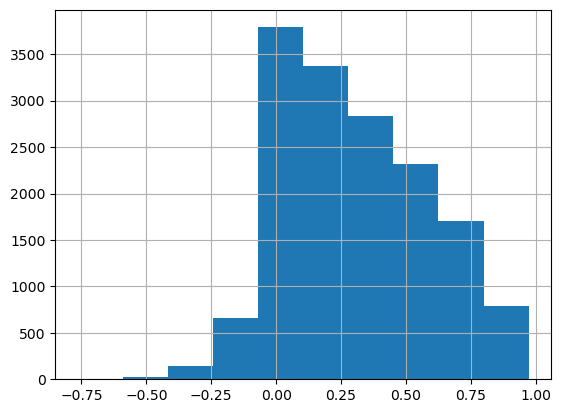

In [63]:
print(np.mean(ITE_peace))
pd.Series(ITE_peace).hist()